### Домашнее задание
1. скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention
2. там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.
3. сделать разбиение набора данных не тренировочную и тестовую выборки
4. сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)
5. провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями
6. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей
7. построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево
8. (опционально) для модели S learner (модель с дополнительным признаком коммуникации) построить зависимость таргета (конверсии - поле conversion) от значения uplift: 1) сделать прогноз и получить uplift для тестовой выборки 2) отсортировать тестовую выборку по uplift по убыванию 3) разбить на децили (pandas qcut вам в помощь) 4) для каждого дециля посчитать среднюю conversion
9. (опционально) построить модель UpliftRandomForestClassifier и попытаться описать словами полученное дерево

In [1]:
%matplotlib inline

import pandas as pd
from sklearn.model_selection import train_test_split
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel, TwoModels, ClassTransformation
from catboost import CatBoostClassifier

In [2]:
# создадим датафрейм с необходимыми данными
df = pd.read_csv('./HW_data.csv')
df.head(5)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


In [3]:
df.describe()

,recency,history,used_discount,used_bogo,is_referral,conversion
count,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000
mean,5.763734,242.085656,0.551031,0.549719,0.502250,0.146781
std,3.507592,256.158608,0.497393,0.497526,0.499999,0.353890
min,1.000000,29.990000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,64.660000,0.000000,0.000000,0.000000,0.000000
50%,6.000000,158.110000,1.000000,1.000000,1.000000,0.000000
75%,9.000000,325.657500,1.000000,1.000000,1.000000,0.000000
max,12.000000,3345.930000,1.000000,1.000000,1.000000,1.000000


In [4]:
df[df['zip_code'] == 'Surburban'].describe()

,recency,history,used_discount,used_bogo,is_referral,conversion
count,28776.000000,28776.000000,28776.000000,28776.000000,28776.000000,28776.000000
mean,5.803100,240.488905,0.549034,0.550111,0.503371,0.139943
std,3.507838,255.448355,0.497599,0.497491,0.499997,0.346934
min,1.000000,29.990000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,63.907500,0.000000,0.000000,0.000000,0.000000
50%,6.000000,155.520000,1.000000,1.000000,1.000000,0.000000
75%,9.000000,324.307500,1.000000,1.000000,1.000000,0.000000
max,12.000000,3345.930000,1.000000,1.000000,1.000000,1.000000


In [5]:
df[df['zip_code'] == 'Urban'].describe()

,recency,history,used_discount,used_bogo,is_referral,conversion
count,25661.000000,25661.000000,25661.000000,25661.000000,25661.000000,25661.000000
mean,5.732084,243.589924,0.552901,0.550095,0.503098,0.139044
std,3.508208,257.971051,0.497203,0.497494,0.500000,0.345999
min,1.000000,29.990000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,65.570000,0.000000,0.000000,0.000000,0.000000
50%,5.000000,160.280000,1.000000,1.000000,1.000000,0.000000
75%,9.000000,327.030000,1.000000,1.000000,1.000000,0.000000
max,12.000000,3215.970000,1.000000,1.000000,1.000000,1.000000


In [6]:
df[df['zip_code'] == 'Rural'].describe()

,recency,history,used_discount,used_bogo,is_referral,conversion
count,9563.000000,9563.000000,9563.000000,9563.000000,9563.000000,9563.000000
mean,5.730210,242.853935,0.552023,0.547527,0.496601,0.188121
std,3.504351,253.395958,0.497312,0.497762,0.500015,0.390829
min,1.000000,29.990000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,65.195000,0.000000,0.000000,0.000000,0.000000
50%,5.000000,159.580000,1.000000,1.000000,0.000000,0.000000
75%,9.000000,325.985000,1.000000,1.000000,1.000000,0.000000
max,12.000000,2080.780000,1.000000,1.000000,1.000000,1.000000


In [7]:
df.isna().sum()

recency          0
history          0
used_discount    0
used_bogo        0
zip_code         0
is_referral      0
channel          0
offer            0
conversion       0
dtype: int64

In [8]:
mapper = {'conversion': 'target', 'offer': 'treatment'}
df.rename(columns=mapper, inplace=True)
df.head(2)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0


In [9]:
df['treatment'].value_counts()

Buy One Get One    21387
Discount           21307
No Offer           21306
Name: treatment, dtype: int64

In [10]:
mapper_ = {'Buy One Get One': 1, 'Discount': 1, 'No Offer': 0}
df['treatment'].replace(to_replace=mapper_, inplace=True)
df.head(5)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,1,0
1,6,329.08,1,1,Rural,1,Web,0,0
2,7,180.65,0,1,Surburban,1,Web,1,0
3,9,675.83,1,0,Rural,1,Web,1,0
4,2,45.34,1,0,Urban,0,Web,1,0


In [11]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('target', 1),
                                                   df['target'], 
                                                   random_state=12,
                                                   stratify=df['target'],
                                                   shuffle=True)

In [12]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler

class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]

In [13]:
continuos_cols = ['recency', 'history']
cat_cols = ['zip_code', 'channel']
base_cols = ['used_discount', 'used_bogo', 'is_referral']

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))

In [14]:
treat_train = X_train['treatment']
treat_test = X_test['treatment']
feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)
feature_processing = Pipeline([('feats', feats)])

feature_processing.fit_transform(X_train)

array([[-0.79126848, -0.51114738,  0.        , ...,  0.        ,
         1.        ,  0.        ],
       [ 1.78260176,  0.62975216,  0.        , ...,  1.        ,
         0.        ,  1.        ],
       [-0.5052829 , -0.83189906,  0.        , ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [-0.21929732, -0.80434887,  0.        , ...,  1.        ,
         0.        ,  1.        ],
       [-1.07725407,  2.17091432,  0.        , ...,  0.        ,
         1.        ,  1.        ],
       [ 0.63865943, -0.02230817,  0.        , ...,  1.        ,
         1.        ,  1.        ]])

In [15]:
models_results = {
    'approach': [],
    'uplift@10%': [],
    'uplift@20%': []
}

SoloModel uplift@10%: 0.0669


<ipython-input-16-1c8d64956808>:16: UserWarning: It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.
  model = model.fit(X_train_, y_train, treat_train)#, estimator_fit_params={'cat_features': cat_features})


ClassTransformation uplift@10%: 0.0687
TwoModels uplift@10%: 0.0492


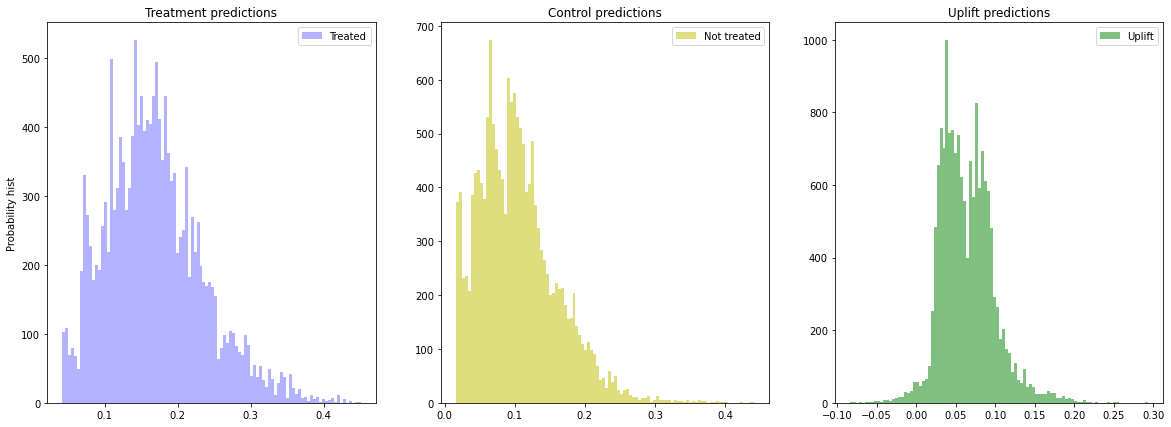

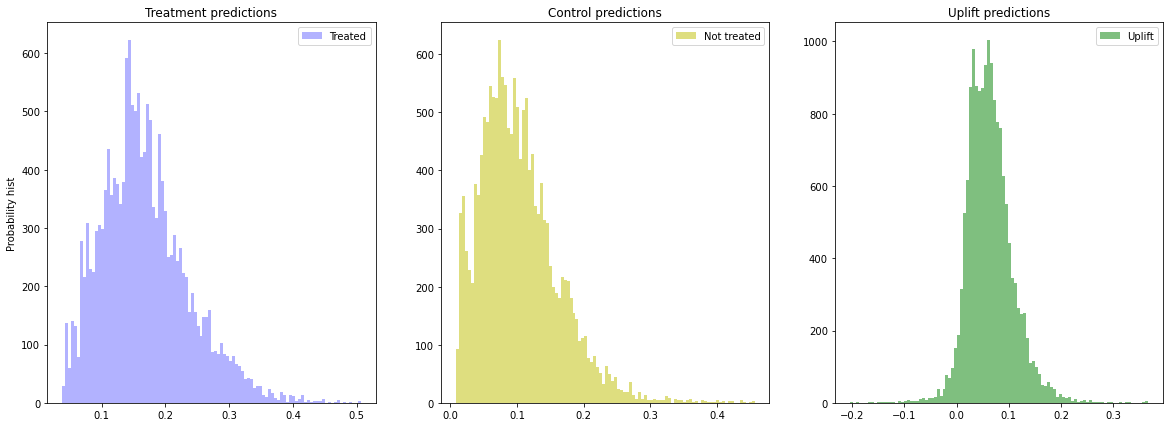

In [16]:
sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
list_model = [sm, ct, tm]
list_name = ['SoloModel', 'ClassTransformation', 'TwoModels']

X_train_ = feature_processing.fit_transform(X_train)
X_test_ = feature_processing.fit_transform(X_test)
i = 0
for model, name in zip(list_model, list_name):
    i += 1
    model = model.fit(X_train_, y_train, treat_train)#, estimator_fit_params={'cat_features': cat_features})
    uplift_sm = model.predict(X_test_)

    model_score = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.1)
    print(f'{name} uplift@10%: {model_score:.4f}')

    models_results['approach'].append(name)
    models_results['uplift@10%'].append(model_score)

    if i != 2:
        # Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
        model_trmnt_preds = model.trmnt_preds_
        # И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
        model_ctrl_preds = model.ctrl_preds_

        # Отрисуем распределения вероятностей и их разность (uplift)
        plot_uplift_preds(trmnt_preds=model_trmnt_preds, ctrl_preds=model_ctrl_preds);

SoloModel uplift@20%: 0.0591


<ipython-input-17-d096044c4768>:4: UserWarning: It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.
  model = model.fit(X_train_, y_train, treat_train)#, estimator_fit_params={'cat_features': cat_features})


ClassTransformation uplift@20%: 0.0466
TwoModels uplift@20%: 0.0459


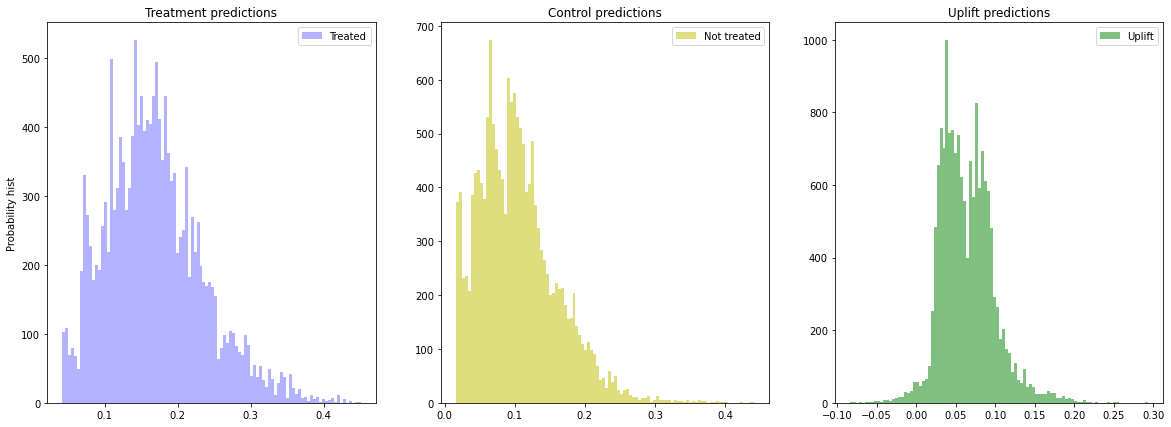

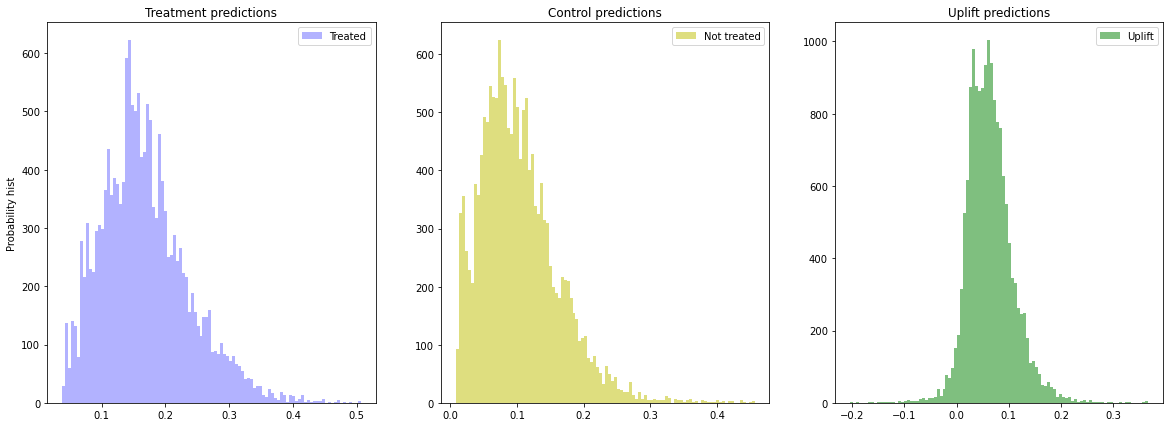

In [17]:
i = 0
for model, name in zip(list_model, list_name):
    i += 1
    model = model.fit(X_train_, y_train, treat_train)#, estimator_fit_params={'cat_features': cat_features})
    uplift_sm = model.predict(X_test_)

    model_score = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.2)
    print(f'{name} uplift@20%: {model_score:.4f}')

    models_results['uplift@20%'].append(model_score)

    if i != 2:
        # Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
        model_trmnt_preds = model.trmnt_preds_
        # И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
        model_ctrl_preds = model.ctrl_preds_

        # Отрисуем распределения вероятностей и их разность (uplift)
        plot_uplift_preds(trmnt_preds=model_trmnt_preds, ctrl_preds=model_ctrl_preds);

In [18]:
models_results

{'approach': ['SoloModel', 'ClassTransformation', 'TwoModels'],
 'uplift@10%': [0.06692200434191717, 0.06868171629277936, 0.04916426919886335],
 'uplift@20%': [0.059051575855407656,
  0.04656116859403531,
  0.045902687730997566]}

In [19]:
pd.DataFrame(data=models_results).sort_values('uplift@20%', ascending=False)

,approach,uplift@10%,uplift@20%
0,SoloModel,0.066922,0.059052
1,ClassTransformation,0.068682,0.046561
2,TwoModels,0.049164,0.045903


В общем случае, если брать по среднему, то одиночная модель показывает лучший результат (т.к. модель с трансформацией на @20 очень сильно просела), двойная модель в аутсайдерах в этой задаче.